In [3]:
import pandas as pd
import os
from scipy.stats import wilcoxon

subjects = ['Linus']
prefix_numbers = ['002']

left_subdivs  = ['SL_APul', 'SL_MPul', 'SL_LPul', 'SL_IPul']
right_subdivs = ['SR_APul', 'SR_MPul', 'SR_LPul', 'SR_IPul']

data = []

for subject in subjects:
    for prefix_number in prefix_numbers:
        def load_df(drug_state):
            path = f'long_correlation_matrix_{subject}_{drug_state}_{prefix_number}.csv'
            if not os.path.exists(path):
                print(f" File not found: {path} — will be skipped.")
                return None
            return pd.read_csv(path)

        df_pre = load_df("predrug")
        df_post = load_df("postdrug")

        if df_pre is None or df_post is None:
            continue

        entry = {'subject': subject}

        def get_mean(df, label, var1_exact, var2_prefix):
            df_filtered = df[
                (df['Variable1'] == var1_exact) &
                df['Variable2'].str.startswith(var2_prefix) &
                (df['Correlation'] != 1)
            ]
            if df_filtered.empty:
                print(f"No data for {subject} – {label}")
                return float('nan')
            if len(df_filtered) < 3:
                print(f" Few data for ({len(df_filtered)}) for {subject} – {label}")
            return df_filtered['Correlation'].mean()

        for subdiv, side in zip(left_subdivs + right_subdivs, ['left'] * 4 + ['right'] * 4):
            for target, label in [('intra', 'CL_' if side == 'left' else 'CR_'),
                                  ('inter', 'CR_' if side == 'left' else 'CL_')]:
                key = f"{subdiv}_{target}"
                entry[f"{key}_pre"]  = get_mean(df_pre,  key + ' pre',  subdiv, label)
                entry[f"{key}_post"] = get_mean(df_post, key + ' post', subdiv, label)

        data.append(entry)

# Convert into dataframe
df_all = pd.DataFrame(data)
print("\n Means per subject")
#print(df_all)

print("\n Means for each subdivision")
for index, row in df_all.iterrows():
   # print(f"\nSubjekt: {row['subject']}")
    for subdiv in left_subdivs + right_subdivs:
        for target in ['intra', 'inter']:
            for condition in ['pre', 'post']:
                key = f"{subdiv}_{target}_{condition}"
                #print(f"{subdiv} {target} ({condition}): {row[key]:.4f}")
df_clean = df_all.dropna()


 Means per subject

 Means for each subdivision


In [6]:
!pip install pingouin

  Using cached pingouin-0.5.5-py3-none-any.whl.metadata (19 kB)
  Using cached pandas_flavor-0.7.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached pingouin-0.5.5-py3-none-any.whl (204 kB)
Using cached pandas_flavor-0.7.0-py3-none-any.whl (8.4 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


## left divisions

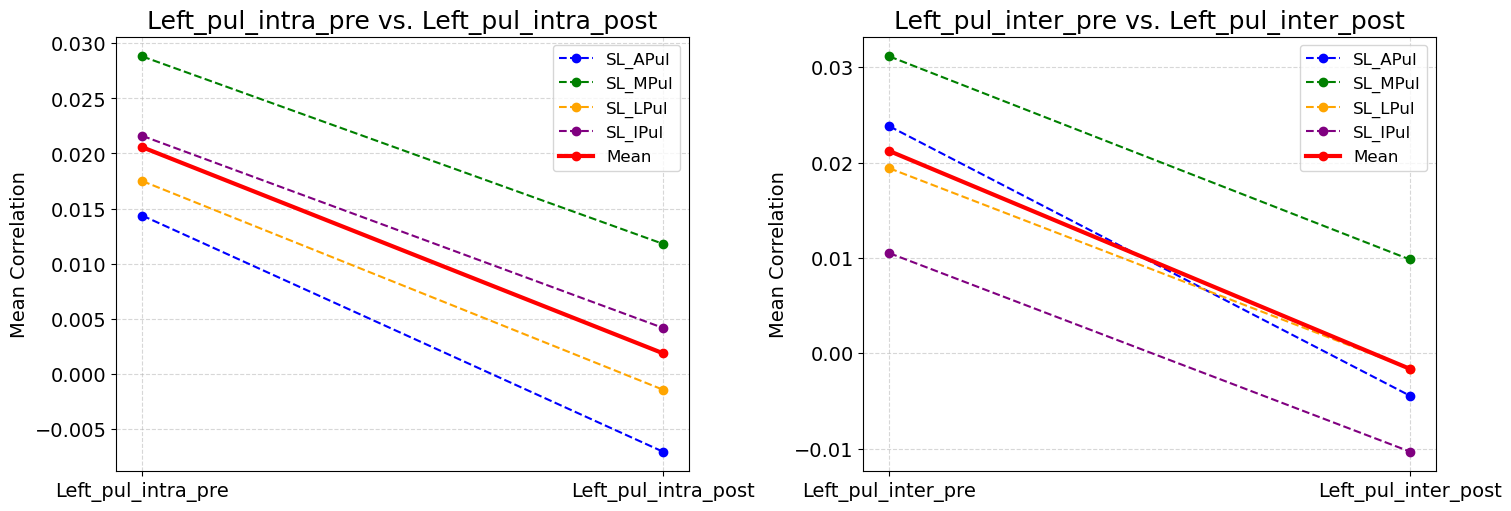

In [4]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([
    [0.0, 0.0, 0.0, 0.0],  # SL_APul
    [0.0, 0.0, 0.0, 0.0],      # SL_MPul
    [0.0, 0.0, 0.0, 0.0],          # SL_LPul
    [0.0, 0.0, 0.0, 0.0]            # SL_IPul
])

subdivision_labels = [
    "SL_APul", "SL_MPul", "SL_LPul", "SL_IPul"
]

# Condition pairs
comparisons = [("Left_pul_intra_pre", "Left_pul_intra_post", 0, 2),
               ("Left_pul_inter_pre", "Left_pul_inter_post", 1, 3)]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

colors = ['blue', 'green', 'orange', 'purple']

for idx, (ax, (cond1, cond2, i, j)) in enumerate(zip(axes, comparisons)):
    mean1 = np.mean(data[:, i])
    mean2 = np.mean(data[:, j])

    for k in range(len(subdivision_labels)):
        ax.plot([0, 1], [data[k, i], data[k, j]],
                marker='o', linestyle='--', color=colors[k],
                label=subdivision_labels[k])
        
    ax.plot([0, 1], [mean1, mean2], marker='o', linestyle='-', color='red', linewidth=3, label='Mean')

    ax.set_xticks([0, 1])
    ax.set_xticklabels([cond1, cond2])
    ax.set_title(f"{cond1} vs. {cond2}", fontsize=18)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_ylabel("Mean Correlation", fontsize=14)
    ax.legend(fontsize=12)
plt.savefig("left_pul_intra_inter_pre_post.png", dpi=300)
plt.show()


In [7]:
import pandas as pd
import pingouin as pg

subject_ids = [f"S{i+1}" for i in range(data.shape[0])]
subdivisions = subdivision_labels
conditions = ["intra_pre", "inter_pre", "intra_post", "inter_post"]

long_rows = []

for subj_idx, subj in enumerate(subject_ids):
    for cond_idx, condition in enumerate(conditions):
        long_rows.append({
            "subject": subj,
            "subdivision": subdivisions[subj_idx],
            "condition": condition,
            "correlation": data[subj_idx, cond_idx]
        })

df_long = pd.DataFrame(long_rows)

# Split 'condition' into two separate factors (e.g., connection_type and drug_state)
df_long[["connection_type", "drug_state"]] = df_long["condition"].str.split("_", expand=True)

#print("\n Long-Format-Table for Anova")
#print(df_long.head())

aov = pg.rm_anova(
    dv="correlation",
    within=["connection_type", "drug_state"],
    subject="subject",
    data=df_long,
    detailed=True
)

#print("\n Repeated Measures ANOVA")
#print(aov)


/opt/conda/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/opt/conda/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


In [8]:
from scipy.stats import ttest_rel, wilcoxon

for conn in ['intra', 'inter']:
    pre_vals = df_long[
        (df_long['connection_type'] == conn) &
        (df_long['drug_state'] == 'pre')
    ].sort_values('subject')['correlation'].values

    post_vals = df_long[
        (df_long['connection_type'] == conn) &
        (df_long['drug_state'] == 'post')
    ].sort_values('subject')['correlation'].values

    #print(f"\n--- {conn.upper()} ---")
    
    if len(pre_vals) == len(post_vals) and len(pre_vals) > 1:
        # Paired t-Test
        t_stat, t_p = ttest_rel(pre_vals, post_vals)
        #print(f"t-Test: t = {t_stat:.4f}, p = {t_p:.4f}")

        # Wilcoxon-Test
        try:
            w_stat, w_p = wilcoxon(pre_vals, post_vals)
            #print(f"Wilcoxon-Test: W = {w_stat:.4f}, p = {w_p:.4f}")
        except ValueError as e:
            #print(f"Wilcoxon test could not be performed: {e}")
    else:
      #  print("Not enough data for a paired test.")


IndentationError: expected an indented block after 'except' statement on line 25 (1808722864.py, line 27)

## Right divisions

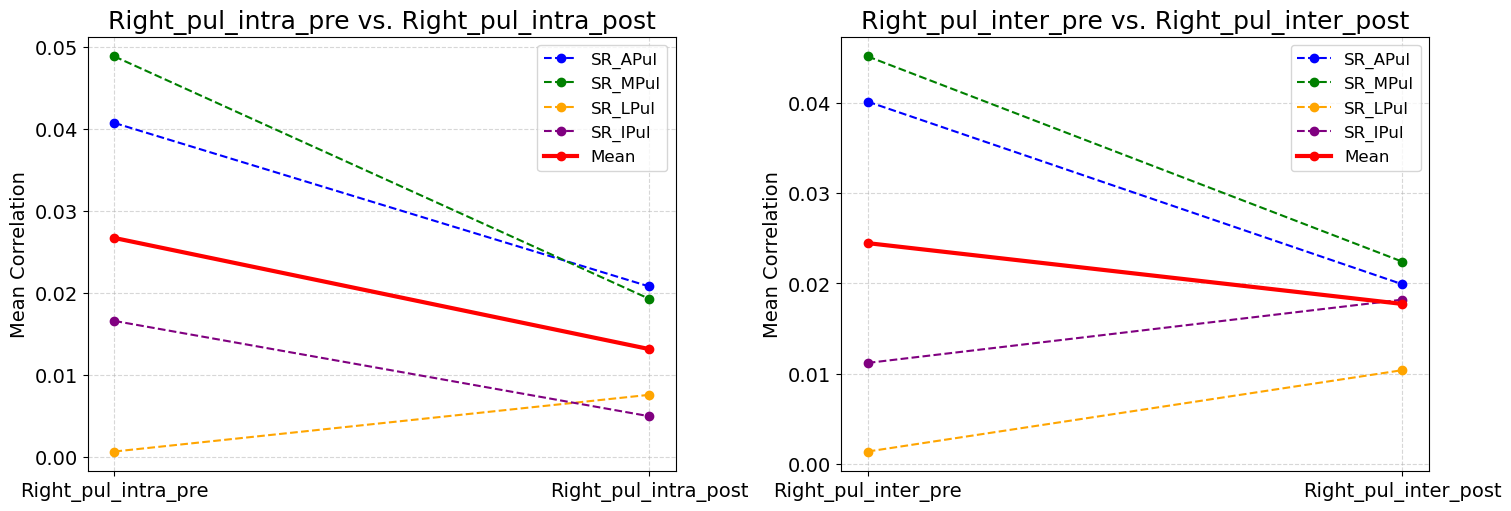

In [18]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([
    [0.0, 0.0, 0.0, 0.0],  # SR_APul
    [0.0, 0.0, 0.0, 0.0],      # SR_MPul
    [0.0, 0.0, 0.0, 0.0],          # SR_LPul
    [0.0, 0.0, 0.0, 0.0]            # SR_IPul
])

# Subdivision Labels
subdivision_labels = [
    "SR_APul", "SR_MPul", "SR_LPul", "SR_IPul"
]

# Condition pairs
comparisons = [("Right_pul_intra_pre", "Right_pul_intra_post", 0, 2),
               ("Right_pul_inter_pre", "Right_pul_inter_post", 1, 3)]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

colors = ['blue', 'green', 'orange', 'purple']

for idx, (ax, (cond1, cond2, i, j)) in enumerate(zip(axes, comparisons)):
    mean1 = np.mean(data[:, i])
    mean2 = np.mean(data[:, j])

    for k in range(len(subdivision_labels)):
        ax.plot([0, 1], [data[k, i], data[k, j]],
                marker='o', linestyle='--', color=colors[k],
                label=subdivision_labels[k])

    ax.plot([0, 1], [mean1, mean2], marker='o', linestyle='-', color='red', linewidth=3, label='Mean')

    ax.set_xticks([0, 1])
    ax.set_xticklabels([cond1, cond2])
    ax.set_title(f"{cond1} vs. {cond2}", fontsize=18)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_ylabel("Mean Correlation", fontsize=14)

    ax.legend(fontsize=12)

#plt.savefig("right_pul_intra_inter_pre_post.png", dpi=300)
#plt.show()


In [9]:
import pandas as pd
import pingouin as pg

subject_ids = [f"S{i+1}" for i in range(data.shape[0])]
subdivisions = subdivision_labels
conditions = ["intra_pre", "inter_pre", "intra_post", "inter_post"]

long_rows = []

for subj_idx, subj in enumerate(subject_ids):
    for cond_idx, condition in enumerate(conditions):
        long_rows.append({
            "subject": subj,
            "subdivision": subdivisions[subj_idx],
            "condition": condition,
            "correlation": data[subj_idx, cond_idx]
        })

df_long = pd.DataFrame(long_rows)

# Split 'condition' into two separate factors (e.g., connection_type and drug_state)
df_long[["connection_type", "drug_state"]] = df_long["condition"].str.split("_", expand=True)

#print("\n Long-Format-Table for ANOVA")
#print(df_long.head())

aov = pg.rm_anova(
    dv="correlation",
    within=["connection_type", "drug_state"],
    subject="subject",
    data=df_long,
    detailed=True
)

#print("\n Repeated Measures ANOVA (Connection × Drug State) ")
#print(aov)


/opt/conda/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/opt/conda/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


In [10]:
from scipy.stats import ttest_rel, wilcoxon

for conn in ['intra', 'inter']:
    pre_vals = df_long[
        (df_long['connection_type'] == conn) &
        (df_long['drug_state'] == 'pre')
    ].sort_values('subject')['correlation'].values

    post_vals = df_long[
        (df_long['connection_type'] == conn) &
        (df_long['drug_state'] == 'post')
    ].sort_values('subject')['correlation'].values

    #print(f"\n--- {conn.upper()} ---")
    
    if len(pre_vals) == len(post_vals) and len(pre_vals) > 1:
       # Paired t-Test
        t_stat, t_p = ttest_rel(pre_vals, post_vals)
        #print(f"t-Test: t = {t_stat:.4f}, p = {t_p:.4f}")

        # Wilcoxon-Test
        try:
            w_stat, w_p = wilcoxon(pre_vals, post_vals)
            #print(f"Wilcoxon-Test: W = {w_stat:.4f}, p = {w_p:.4f}")
        except ValueError as e:
            #print(f"Wilcoxon test could not be performed: {e}")
    else:
        #print("Not enough data for a paired test.")


IndentationError: expected an indented block after 'except' statement on line 25 (2076490625.py, line 27)